# Pareto-NBD Population Model



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import numpy as np
import warnings

from pymc_marketing.clv.models import ParetoNBDModel
from pymc_marketing.clv.distributions import ParetoNBD
from pymc_marketing.clv.utils import clv_summary

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, QuantileTransformer

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load Data

We will be working with the CDNOW Sample dataset, a common benchmark dataset in research for CLV and BTYD models

Also consider these datasets: <br>
https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction<br>
https://www.kaggle.com/datasets/vijayuv/onlineretail

In [2]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"

raw_trans = pd.read_csv(url_cdnow)

raw_trans.head(5)

,_id,id,date,cds_bought,spent
0,4,1,19970101,2,29.33
1,4,1,19970118,2,29.73
2,4,1,19970802,1,14.96
3,4,1,19971212,2,26.48
4,21,2,19970101,3,63.34


<Axes: xlabel='date'>

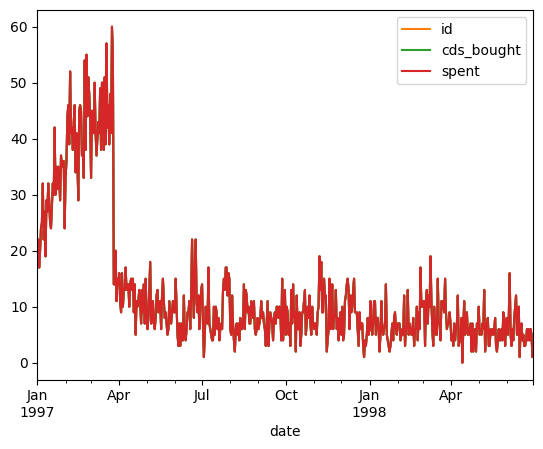

In [3]:
raw_trans["date"] = pd.to_datetime(raw_trans['date'], format = "%Y%m%d")
daily_trans = raw_trans.resample("D", on="date").count()
daily_trans.plot()

In [4]:
df = clv_summary(raw_trans, 
            customer_id_col = "id", 
            datetime_col = "date",
            datetime_format = "%Y%m%d",
            time_unit = "D" #aggregating to weekly can speed up sampling if the use case allows it
           )

cds = raw_trans.groupby("id")["cds_bought"].mean()
spent = raw_trans.groupby("id")["spent"].mean()
covar_df = pd.DataFrame({"cds_bought": cds, "spent": spent})

# Can centering the data improve convergence?
# Zeroes in the data are not processed, which seems to slow down training time
# transformer = QuantileTransformer(output_distribution='normal').fit(covar_df) #uniform
# transformed_covars = transformer.transform(covar_df)

# Keep data positive so coefficients are easily interpretable
scaler = MinMaxScaler().fit(covar_df)
scaled_covars = scaler.transform(covar_df)

df["cds_bought"] = scaled_covars[...,0]
df["spent"] = scaled_covars[...,1]
df = df.rename(columns = {"id": "customer_id"})

df.describe()

,customer_id,frequency,recency,T,cds_bought,spent
count,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000
mean,1179.000000,1.840899,130.447179,502.011031,0.030231,0.063984
std,680.551615,3.772237,176.874156,23.288656,0.050373,0.058634
min,1.000000,0.000000,0.000000,462.000000,0.000000,0.000000
25%,590.000000,0.000000,0.000000,482.000000,0.000000,0.030061
50%,1179.000000,0.000000,0.000000,502.000000,0.019231,0.049285
75%,1768.000000,2.000000,279.000000,521.000000,0.038462,0.075961
max,2357.000000,43.000000,535.000000,545.000000,1.000000,1.000000


/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

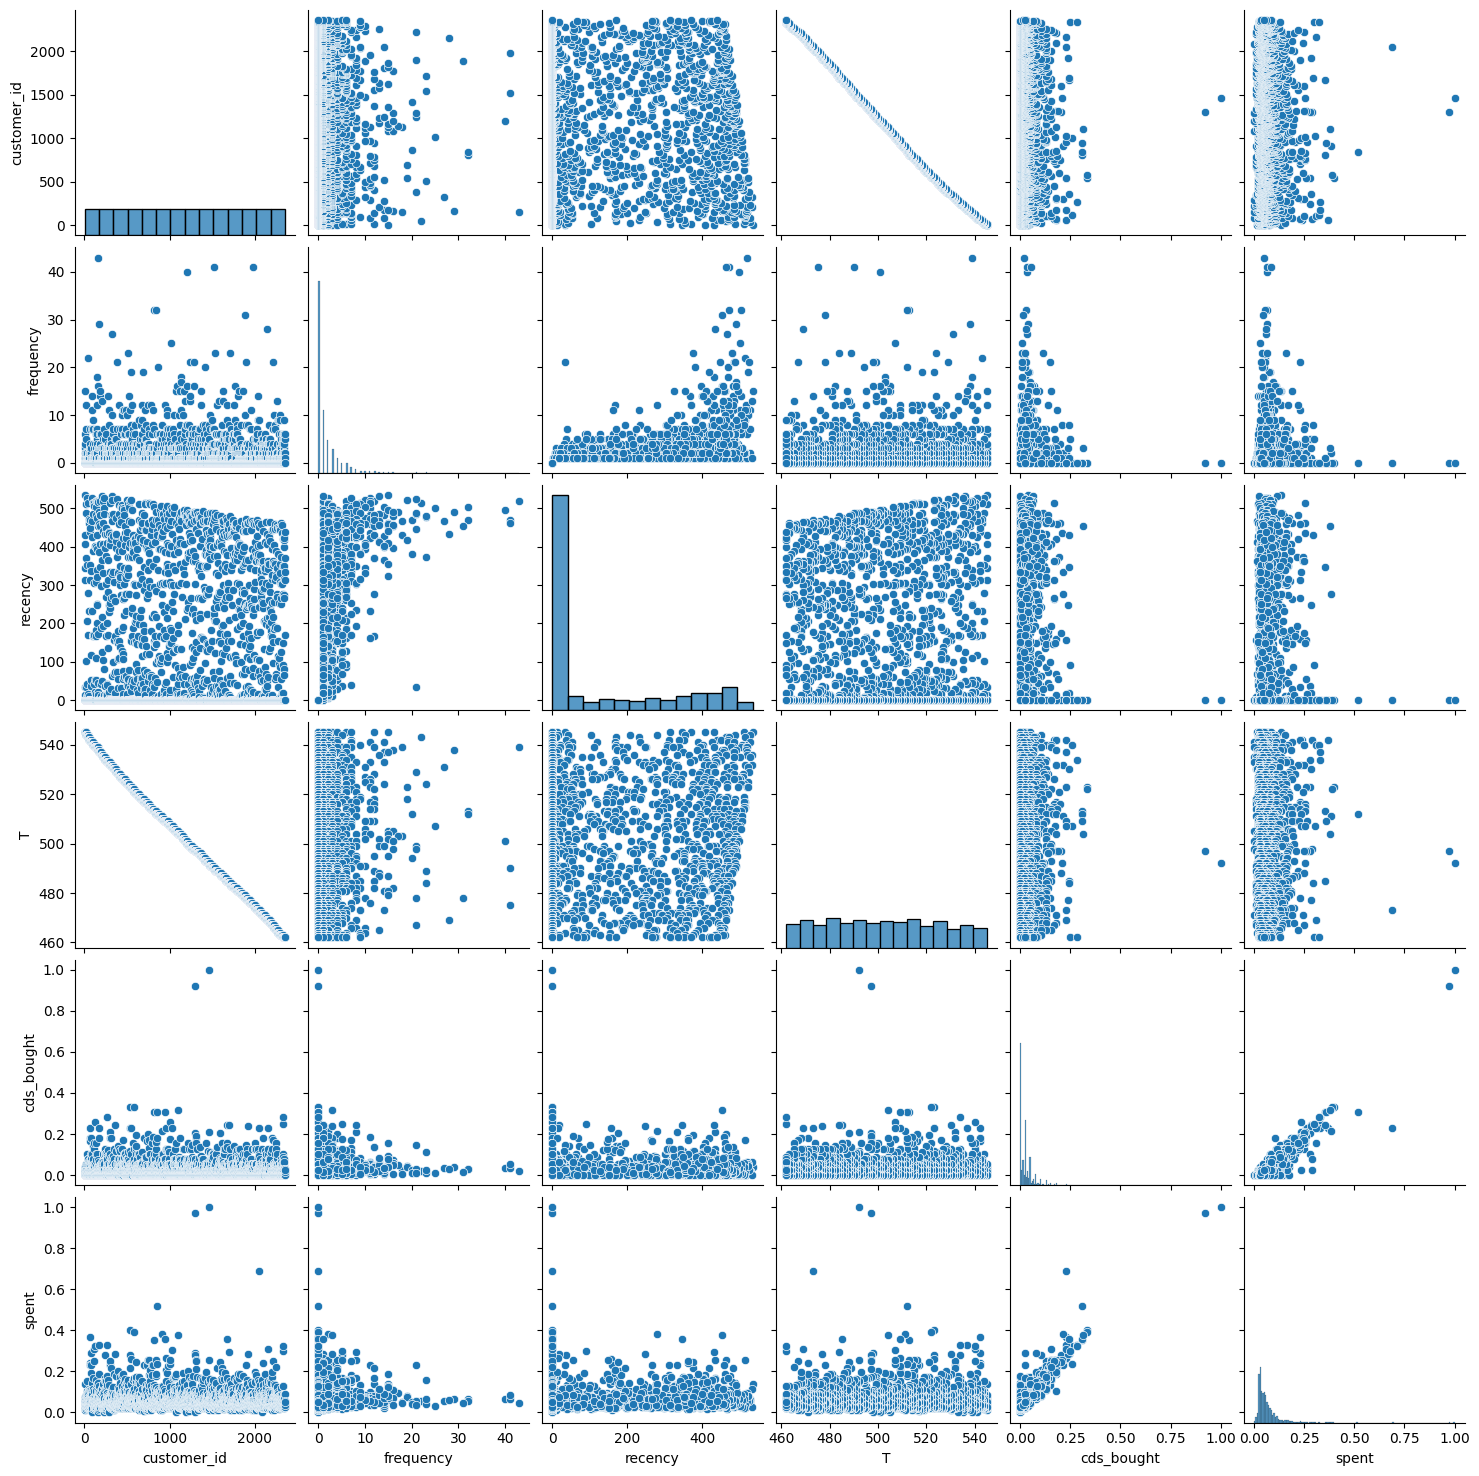

In [5]:
sns.pairplot(df)

## Build Model

This model uses Weibull default priors. For an interactive PDF go here:
https://homepage.divms.uiowa.edu/~mbognar/applets/weibull.html

The Weibull distribution is an intuitive prior distribution choice for the Pareto/NBD model because the `beta` parameter loosely corresponds to the expected value, and an `alpha` parameter value of 2 will rule out values which may cause sampling instability without being too restrictive. The Weibull distribution is also a variant of the generalized Gamma distribution that forms the conjugate priors of this model.

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

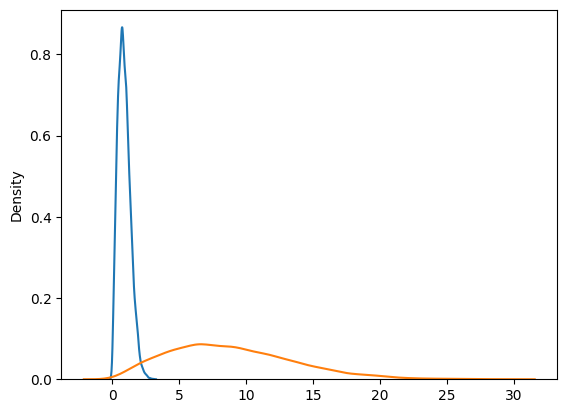

In [6]:
shape_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=1, size=10_000))
scale_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=10, size=10_000))

sns.kdeplot(shape_prior)
sns.kdeplot(scale_prior);

# ParetoNBD Model in `pymc_marketing`

Build models fit with both MAP and MCMC

In [10]:
model_config = {
    "r_prior": {"dist": "HalfFlat", "kwargs": {}},
    "alpha_prior": {"dist": "HalfFlat", "kwargs": {}},
    "s_prior": {"dist": "HalfFlat", "kwargs": {}},
    "beta_prior": {"dist": "HalfFlat", "kwargs": {}},
    }

map_fit = ParetoNBDModel(df,model_config = model_config)

map_fit
# map_fit.fit()

# print("MAP Fit:") 
# print(map_fit.fit_summary())

# pm.model_to_graphviz(map_fit.model)

AttributeError: 'NoneType' object has no attribute 'str_repr'

In [139]:

covar_model = ParetoNBDModel(data=df,
                             pr_covar_columns=["cds_bought", "spent"], 
                             dr_covar_columns=["cds_bought", "spent"],
                            sampler_config = {"idata_kwargs": {"log_likelihood": True}}
                            )
covar_model.build_model()
pm.model_to_graphviz(covar_model.model)
# TODO: build_model() and fit() methods both return NoneType objects. 
#pnbd.idata not yet created at this point

# pnbd.sample_prior_predictive() can be used after calling build_model and before fitting, 
# it will return an xarray.Dataset, but also create the pnbd.idata arviz.InferenceData object
#map_fit.sample_prior_predictive()

# fitting the model will overwrite the prior_predictive idata object
covar_model.fit(fit_method='map')

#df['exp_prchs_map'] = covar_model.expected_purchases(future_t = 10).mean(("chain", "draw"))

In [140]:
covar_model.fit_summary(var_names=["r","alpha0", "s", "beta0", "pr_coeff", "dr_coeff"])

# alpha = map_fit.fit_result["alpha_dim_0"]
# beta = map_fit.fit_result["beta_dim_0"]

# alpha.median()

# az.plot_dist(alpha)

r               0.485
alpha0         57.552
s               0.313
beta0          19.172
pr_coeff[0]     5.365
pr_coeff[1]    -4.918
dr_coeff[0]    -7.902
dr_coeff[1]    -8.818
Name: value, dtype: float64

In [ ]:
Negative purchase rate coefficients suggest variables increase time between transactions
Negative dropout coefficient values suggest these variables increase the active time period of a customer.

In [141]:
# fit same model with MCMC to compare return arviz outputs
# Note that HalFlat priors take a very long time to sample
#covar_model.fit(fit_method='mcmc')

# Gradient-free DEMetroplis sampling is vastly faster
# :20-:24 w/ daily pos-scaled, 1.16-1.43 rhat
# :18-:19 w/ weekly pos-scaled, 1.08-1.26 rhat

# :41 w/ quantile normal pos-scaled, daily, 1.34 rhat
# :29-1:01 w/ quantile normal pos-scaled, weekly, 1.08 rhat
# :31-2:06 w/ quantile uniform, daily, 1.55 rhat!
# :19 w/ quantile uniform, weekly, 1.05 rhat
with covar_model.model:
    covar_model.idata = pm.sample(step=pm.DEMetropolisZ(),tune=5000, draws=5000, idata_kwargs={"log_likelihood": True})

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op hyp2f1 does not provide

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 19 seconds.
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


WAIC could serve as an evaluation metric:
https://python.arviz.org/en/stable/api/generated/arviz.waic.html#arviz.waic

In [142]:
#az.waic(idata)
covar_model.fit_summary(var_names=["r","alpha0", "s", "beta0", "pr_coeff", "dr_coeff"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.486,0.027,0.431,0.536,0.001,0.001,399.0,779.0,1.02
alpha0,58.975,4.457,50.812,67.920,0.316,0.225,202.0,351.0,1.03
s,0.318,0.033,0.257,0.379,0.002,0.001,367.0,653.0,1.02
beta0,20.559,4.429,12.350,28.741,0.322,0.228,185.0,1018.0,1.03
pr_coeff[0],3.718,3.517,-1.353,10.385,0.940,0.679,14.0,37.0,1.21
pr_coeff[1],-3.702,2.627,-8.704,0.332,0.599,0.430,19.0,35.0,1.15
dr_coeff[0],-12.459,11.606,-31.294,3.058,4.392,3.245,8.0,37.0,1.43
dr_coeff[1],-6.493,7.326,-19.902,2.445,2.490,1.824,10.0,300.0,1.33


In [78]:
# posterior predictive checks not directly supported,
# because GammaGammaModel and BetaGeoModel use Potentials to calculate logp
with mcmc_fit.model:
    post_idata = pm.sample_posterior_predictive(mcmc_fit.idata)

mcmc_fit.idata.extend(post_idata)
mcmc_fit.idata

NameError: name 'mcmc_fit' is not defined

In [ ]:
mcmc_fit.fit_summary()

In [ ]:
az.plot_posterior(covar_model.idata, ref_val=list(lt_fit.values()))

In [33]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

AttributeError: 'InferenceData' object has no attribute 'prior_predictive'

<Axes: title={'center': 'Plot Post Predictive'}>

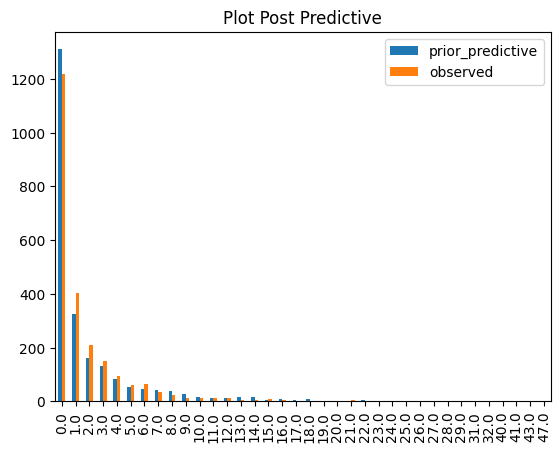

In [34]:
post_pred_freq = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_post_pred = pd.DataFrame({"prior_predictive": post_pred_freq, "observed": obs_freq})
plot_post_pred.plot(kind="bar", title = "Plot Post Predictive")

#az.plot_dist(post_idata.posterior_predictive)


In [35]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
prior_pred_freq_array = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Prior Predictive Difference Plot")
az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Prior Predictive ECDF Plot")

AttributeError: 'InferenceData' object has no attribute 'prior_predictive'

Text(0.5, 1.0, 'Posterior Predictive ECDF Plot')

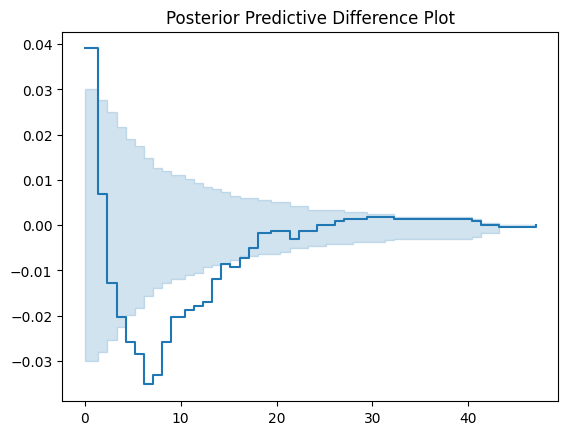

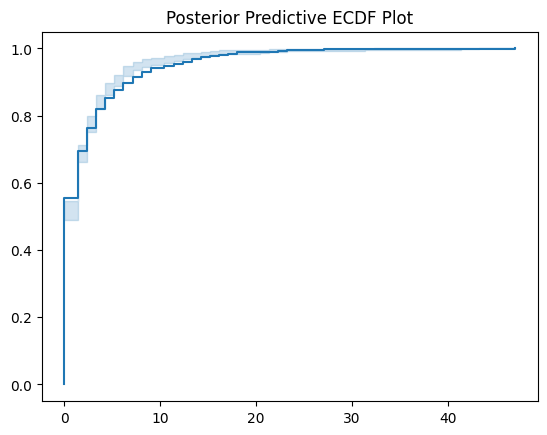

In [36]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
post_pred_freq_array = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Posterior Predictive Difference Plot")
az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Posterior Predictive ECDF Plot")

https://python.arviz.org/en/stable/api/generated/arviz.plot_ecdf.html#arviz.plot_ecdf

# Plot the `ParetoNBDModel` Dropout and Purchase Rate Distributions for New Customers

In [12]:
# customer_dropout_mcmc = mcmc_fit.distribution_new_customer_dropout()
# customer_purchase_rate_mcmc = mcmc_fit.distribution_new_customer_purchase_rate()
# customer_population_mcmc = mcmc_fit.distribution_customer_population()

customer_dropout_map = map_fit.distribution_new_customer_dropout()
customer_purchase_rate_map = map_fit.distribution_new_customer_purchase_rate()
customer_population_map = map_fit.distribution_customer_population()


Sampling: [population_dropout]


TypeError: ('Wrong number of dimensions: expected 0, got 1 with shape (2357,).', 'Container name "beta"')

In [38]:
customer_dropout_mcmc.shape

#(1, 1, 2357, 2)
#(4, 1000, 2357, 2)


(4, 1000)

In [39]:
N = 2357
chains = 2
draws = 50

rng = np.random.default_rng(34)

mock_idata = az.from_dict(
    {
        "r": rng.normal(0.55, 1e-3, size=(chains, draws)),
        "alpha": rng.normal(
           10.56, 1e-3, size=(chains, draws)
        ),
        "s": rng.normal(.68, 1e-3, size=(chains, draws)),
        "beta": rng.normal(
            11.68, 1e-3, size=(chains, draws)
        ),
    }
)

mock_idata = az.from_dict(
                {
                    "r": .55,
                    "alpha": 10.56,
                    "s": .68,
                    "beta": 11.68,
                }
            )



fake_model = ParetoNBDModel(df)
fake_model.idata=mock_idata

fake_model.distribution_customer_population(T=np.tile(100,1000))

# obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
# prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

# plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
# plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

Sampling: [customer_population]


<xarray.DataArray 'customer_population' (chain: 1, draw: 1,
                                         customer_population_dim_2: 1000,
                                         customer_population_dim_3: 2)>
array([[[[ 2.92483285,  3.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [96.1100888 ,  3.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]]])
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0
  * customer_population_dim_2  (customer_population_dim_2) int64 0 1 ... 998 999
  * customer_population_dim_3  (customer_population_dim_3) int64 0 1

Text(0.5, 1.0, 'Customer Dropout Distribution')

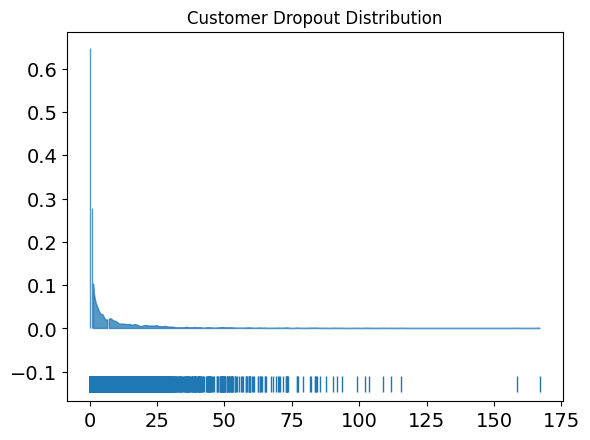

In [40]:
az.plot_dist(customer_dropout_mcmc, rug=True, quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Distribution")

Text(0.5, 1.0, 'Customer Dropout Rate Distribution w/ MAP Fit')

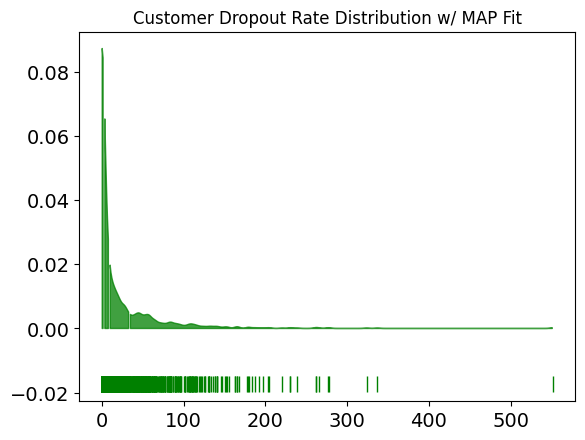

In [41]:
# Note the array indexing required for MAP fit plotting
az.plot_dist(customer_dropout_map[0][0], rug=True, color='g', quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Rate Distribution w/ MAP Fit")

In [34]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
#prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()
customer_population_map

# actual_counts = pd.Series(x).value_counts().sort_index()
# simulated_counts = pd.Series(model_freq).value_counts().sort_index()

# plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
# plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

<xarray.DataArray 'customer_population' (chain: 4, draw: 1000,
                                         customer_population_dim_2: 2357,
                                         customer_population_dim_3: 2)>
array([[[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [33.22348507,  3.        ],
         [17.78219702,  5.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [15.12256784,  1.        ]],

        [[36.55367967,  5.        ],
         [30.82568583,  2.        ],
         [ 0.        ,  0.        ],
         ...,
...
         ...,
         [ 0.        ,  0.        ],
         [19.43196482,  3.        ],
         [ 0.        ,  0.        ]],

        [[36.3525494 ,  6.        ],
         [ 0.        ,  0.        ],
         [38.4767482 , 12.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [26.8154956 , 10.        ]],

        [[ 0.        ,  0.        ],
         [33.953614  ,  7.        ],
         [19.74782928,  5.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 6.49108868,  1.        ],
         [13.13369364,  4.        ]]]])
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * customer_population_dim_2  (customer_population_dim_2) int64 0 1 ... 2356
  * customer_population_dim_3  (customer_population_dim_3) int64 0 1

# Prior Predictive Plots for the Latent Dropout and Purchase Rate Distributions  are doable, but not directly supported. It's also important to know that since both distributions have identical Priors, there is no difference in plotting between them.

array([[<Axes: title={'center': 'x'}>]], dtype=object)

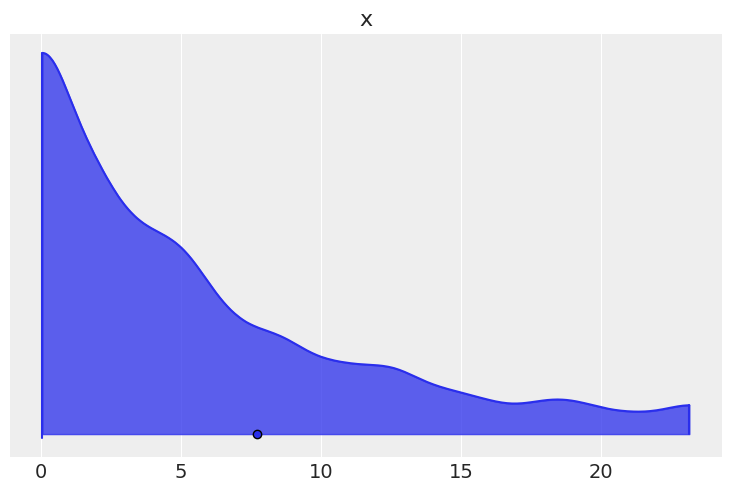

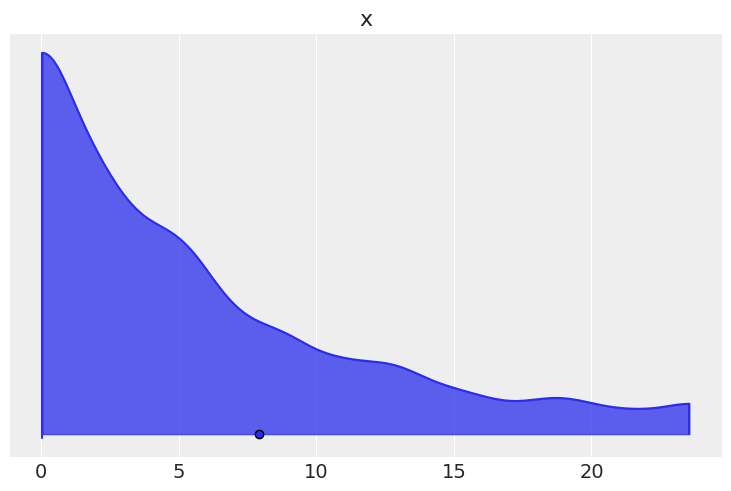

In [204]:
r_prior = mcmc_fit.idata.prior["r"]
alpha_prior = mcmc_fit.idata.prior["alpha"]
s_prior = mcmc_fit.idata.prior["s"]
beta_prior = mcmc_fit.idata.prior["beta"]

purchase_rate_dist = pm.draw(  
    pm.Gamma.dist(  
        alpha=r_prior.values[..., None].mean(),  
        beta=1 / alpha_prior.values[..., None].mean(),  
        shape=1000,  
    ),  
    random_seed=42)

dropout_rate_dist = pm.draw(  
    pm.Gamma.dist(  
        alpha=s_prior.values[..., None].mean(),  
        beta=1 / beta_prior.values[..., None].mean(),  
        shape=1000,  
    ),  
    random_seed=42)

az.plot_density(purchase_rate_dist,point_estimate="mean", shade=.75)
az.plot_density(dropout_rate_dist,point_estimate="mean", shade=.75)

# Predictive Methods for `ParetoNBDModel`

In [24]:
pnbd_map.save('pnbd.nc')
pnbd_map.load('pnbd.nc')

# Append all predictive methods to a pandas dataframe
#df['exp_prchs_mcmc'] = pnbd_mcmc.expected_purchases(future_t = 10).mean(("chain", "draw"))
df['exp_prchs_map'] = pnbd_map.expected_purchases(future_t = 10).mean(("chain", "draw"))

#df['prob_alive_mcmc'] = pnbd_mcmc.expected_probability_alive(future_t = 10).mean(("chain", "draw"))
df['prob_alive_map'] = pnbd_map.expected_probability_alive(future_t = 10).mean(("chain", "draw"))

#df['prchs_prob_mcmc'] = pnbd_mcmc.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))
df['prchs_prob_map'] = pnbd_map.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))

# This value does not change from customer to customer, but is shown here for completeness
#df['new_customer_mcmc'] = pnbd_mcmc.expected_purchases_new_customer(t = 100).mean().values
df['new_customer_map'] = pnbd_map.expected_purchases_new_customer(t = 100).mean().values

# For single customer predictions, arguments must still be provided as lists or numpy arrays
# Array lengths must match for all arguments
# pnbd_mcmc.expected_purchases(future_t = 10,
#                              customer_id = [1000],
#                              frequency = np.array([3]),
#                              recency = [20],
#                              T = [30]).mean(("chain", "draw"))

# # Use a for loop or list comprehension to iterate over multiple arguments:
# [pnbd_mcmc.expected_purchases(future_t = t) for t in [10,9,8]]

df.head(10)

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:175: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


,frequency,recency,T,monetary_value,customer_id,exp_prchs_mcmc,exp_prchs_map,prob_alive_mcmc,prob_alive_map,prchs_prob_map,new_customer_map
0,2,30.43,38.86,22.35,0,0.426163,0.429898,0.781540,0.789804,0.082505,2.257801
1,1,1.71,38.86,11.77,1,0.049964,0.050083,0.150524,0.151008,0.008571,2.257801
2,0,0.00,38.86,0.00,2,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
3,0,0.00,38.86,0.00,3,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
4,0,0.00,38.86,0.00,4,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
5,7,29.43,38.86,73.74,5,1.087263,1.102017,0.675588,0.685516,0.110536,2.257801
6,1,5.00,38.86,11.77,6,0.076542,0.077453,0.230524,0.233532,0.013254,2.257801
7,0,0.00,38.86,0.00,7,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
8,2,35.71,38.86,25.55,8,0.469376,0.471763,0.860708,0.866718,0.090540,2.257801
9,0,0.00,38.86,0.00,9,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
